<a href="https://colab.research.google.com/github/ernesto-miguez/UOC/blob/main/TFM/Comparaci%C3%B3n_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import time
import seaborn as sns

## 1. LORAWAN

### Carga de datos

In [ ]:
trn_crd = pd.read_csv('LWAT01_trncrd.csv', header=None, usecols=[0, 1])
trn_rss = pd.read_csv('LWAT01_trnrss.csv', header=None, low_memory=False)
tst_crd = pd.read_csv('LWAT01_tstcrd.csv', header=None, usecols=[0, 1])
tst_rss = pd.read_csv('LWAT01_tstrss.csv', header=None)

### Definición distancia

In [ ]:
def haversine(coord1, coord2):
    # Radio de la Tierra en metros
    R = 6371000

    lon1, lat1 = coord1
    lon2, lat2 = coord2

    # Diferencia de coordenadas
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Calcular la distancia usando la fórmula del haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c

    return distance

### KNN

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=12)
knn_model.fit(trn_rss, trn_crd)

# Medir el tiempo de predicción
start_time = time.time()
predicted_crd = knn_model.predict(tst_rss)
end_time = time.time()

# Calcular el tiempo de predicción
prediction_time = end_time - start_time

# Convertimos a array
tst_crd_array = np.array(tst_crd)

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
distances_knn = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Calcular el error medio
mean_error = np.mean(distances_knn)

print("Error medio: " + str(np.round(mean_error, 2)) + " m", "Tiempo de predicción: " + str(np.round(prediction_time, 4)) + " segundos")

Error medio: 475.8 m Tiempo de predicción: 60.3428 segundos


### FCN

In [ ]:
# Definir la arquitectura de la red neuronal
class FingerprintingNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 2)  # Salida de 2 dimensiones para las coordenadas (longitud, latitud)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.sigmoid(self.fc4(out))
        return out

# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = R * c

        return torch.mean(distance)

# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo
input_size = trn_rss.shape[1]
hidden_size = 100
model = FingerprintingNN(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
#criterion = nn.MSELoss()
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass y cálculo de la pérdida
    outputs = model(trn_rss_tensor)
    loss = criterion(outputs, trn_crd_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
with torch.no_grad():
  start_time = time.time()
  predicted_crd_tensor = model(tst_rss_tensor)
  end_time = time.time()
  prediction_time = end_time - start_time


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
predicted_crd = predicted_crd_tensor.numpy()
true_crd = tst_crd_tensor.numpy()
distances_fcn = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

Epoch [10/100], Loss: 2366383.2500
Epoch [20/100], Loss: 650750.5625
Epoch [30/100], Loss: 477126.0938
Epoch [40/100], Loss: 243893.3281
Epoch [50/100], Loss: 174788.0469
Epoch [60/100], Loss: 143976.2969
Epoch [70/100], Loss: 102631.9453
Epoch [80/100], Loss: 87661.4844
Epoch [90/100], Loss: 73701.1328
Epoch [100/100], Loss: 65199.6914
Error medio (distancia haversine): 81707.12 m
Tiempo de predicción: 0.0549 segundos


### LSTM

Epoch [1/100], Training Loss: 508450.7498, Validation Loss: 24238.8027
Epoch [2/100], Training Loss: 82318.9971, Validation Loss: 14640.5283
Epoch [3/100], Training Loss: 70358.5653, Validation Loss: 13127.8154
Epoch [4/100], Training Loss: 62960.8780, Validation Loss: 10124.0020
Epoch [5/100], Training Loss: 59101.4521, Validation Loss: 9516.1514
Epoch [6/100], Training Loss: 56621.3301, Validation Loss: 14982.5615
Epoch [7/100], Training Loss: 54660.0029, Validation Loss: 11086.5859
Epoch [8/100], Training Loss: 52510.9654, Validation Loss: 9405.8604
Epoch [9/100], Training Loss: 50768.0106, Validation Loss: 10426.1455
Epoch [10/100], Training Loss: 49187.3951, Validation Loss: 9802.5293
Epoch [11/100], Training Loss: 47891.1810, Validation Loss: 8358.0664
Epoch [12/100], Training Loss: 46510.0651, Validation Loss: 8462.5508
Epoch [13/100], Training Loss: 45281.1611, Validation Loss: 6717.1250
Epoch [14/100], Training Loss: 43942.0753, Validation Loss: 8710.8740
Epoch [15/100], Train

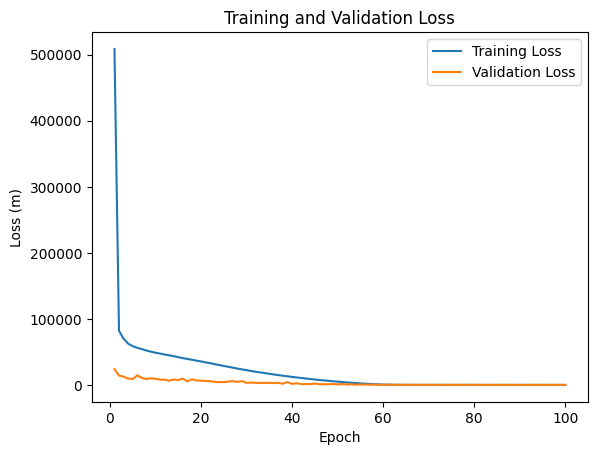

Error medio (distancia haversine): 538.07 m
Tiempo de predicción: 0.1655 segundos


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo y medir el tiempo de predicción
with torch.no_grad():
    start_time = time.time()
    predicted_crd_tensor = model(tst_rss_tensor)
    end_time = time.time()
    prediction_time = end_time - start_time

# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
predicted_crd = predicted_crd_tensor.numpy()
true_crd = tst_crd_tensor.numpy()
distances_lstm = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio y el tiempo de predicción
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m")
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

### RNN

Epoch [1/100], Training Loss: 1430373.6305, Validation Loss: 827601.1250
Epoch [2/100], Training Loss: 621648.9473, Validation Loss: 705295.9375
Epoch [3/100], Training Loss: 591897.1077, Validation Loss: 708944.8125
Epoch [4/100], Training Loss: 385051.5481, Validation Loss: 730200.6250
Epoch [5/100], Training Loss: 191239.1596, Validation Loss: 705487.1875
Epoch [6/100], Training Loss: 117262.9004, Validation Loss: 372909.3750
Epoch [7/100], Training Loss: 105507.8229, Validation Loss: 123447.2109
Epoch [8/100], Training Loss: 105824.8205, Validation Loss: 704206.2500
Epoch [9/100], Training Loss: 101616.8025, Validation Loss: 704371.9375
Epoch [10/100], Training Loss: 98453.7278, Validation Loss: 707762.0000
Epoch [11/100], Training Loss: 96882.1631, Validation Loss: 498261.8438
Epoch [12/100], Training Loss: 94935.1765, Validation Loss: 312917.2500
Epoch [13/100], Training Loss: 86985.6651, Validation Loss: 164305.5312
Epoch [14/100], Training Loss: 84640.8073, Validation Loss: 704

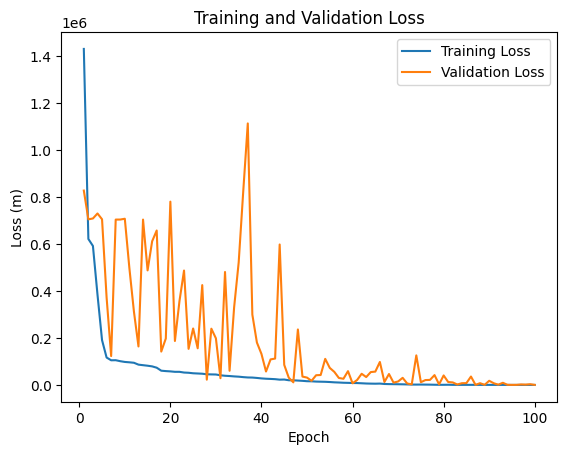

Error medio (distancia haversine): 791.26 m
Tiempo de predicción: 0.3177 segundos


In [ ]:
# Define la arquitectura de la red RNN
class FingerprintingRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.RNN(input_size, hidden_size, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(self.bn1(out))
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingRNN(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    start_time = time.time()
    predicted_crd_tensor = model(tst_rss_tensor)
    end_time = time.time()
    prediction_time = end_time - start_time


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
predicted_crd = predicted_crd_tensor.numpy()
true_crd = tst_crd_tensor.numpy()
distances_rnn = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

### XGBoost

In [ ]:
# Convertir todas las columnas a tipo numérico
trn_rss_num = trn_rss.apply(pd.to_numeric, errors='coerce')
trn_crd_num = trn_crd.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
trn_rss_num.dropna(inplace=True)
trn_crd_num.dropna(inplace=True)

# Convertir a array
tst_crd_array = tst_crd.values

# Entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(trn_rss_num, trn_crd_num)

# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c

        return np.mean(distance)

# Realizar predicciones en el conjunto de prueba
start_time = time.time()
predicted_crd = model.predict(tst_rss)
end_time = time.time()
prediction_time = end_time - start_time

# Calcular el error medio
criterion2 = HaversineLoss()
mean_error = criterion2(predicted_crd, tst_crd_array).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
distances_xgboost = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

Error medio (distancia haversine): 600.66 m
Tiempo de predicción: 0.0668 segundos


### Gráfico CDF

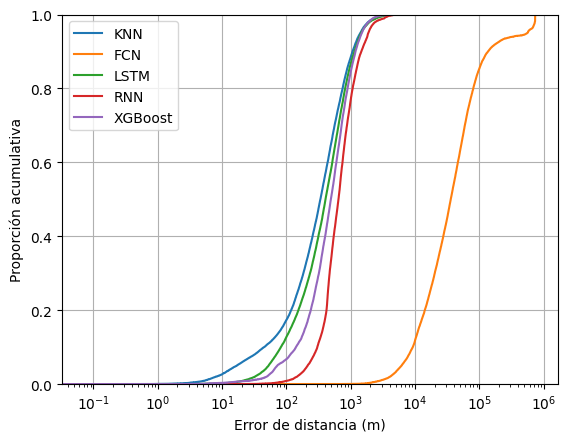

In [ ]:
# Generar el gráfico CDF
sns.ecdfplot(distances_knn, label='KNN')
sns.ecdfplot(distances_fcn, label='FCN')
sns.ecdfplot(distances_lstm, label='LSTM')
sns.ecdfplot(distances_rnn, label='RNN')
sns.ecdfplot(distances_xgboost, label='XGBoost')
plt.xscale('log')  # Cambiar la escala a logarítmica
plt.xlabel('Error de distancia (m)')
plt.ylabel('Proporción acumulativa')
plt.legend()
plt.grid(True)
plt.show()

## 2. Sigfox

### Carga de datos

In [ ]:
trn_crd = pd.read_csv('SFAT01_trncrd.csv', header=None, usecols=[0, 1])
trn_rss = pd.read_csv('SFAT01_trnrss.csv', header=None, low_memory=False)
tst_crd = pd.read_csv('SFAT01_tstcrd.csv', header=None, usecols=[0, 1])
tst_rss = pd.read_csv('SFAT01_tstrss.csv', header=None)

### KNN

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=21)
knn_model.fit(trn_rss, trn_crd)

# Medir el tiempo de predicción
start_time = time.time()
predicted_crd = knn_model.predict(tst_rss)
end_time = time.time()

# Calcular el tiempo de predicción
prediction_time = end_time - start_time

# Convertimos a array
tst_crd_array = np.array(tst_crd)

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
distances_knn = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Calcular el error medio
mean_error = np.mean(distances_knn)

print("Error medio: " + str(np.round(mean_error, 2)) + " m", "Tiempo de predicción: " + str(np.round(prediction_time, 4)) + " segundos")

Error medio: 801.53 m Tiempo de predicción: 1.4418 segundos


### FCN

In [ ]:
# Definir la arquitectura de la red neuronal
class FingerprintingNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 2)  # Salida de 2 dimensiones para las coordenadas (longitud, latitud)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.sigmoid(self.fc4(out))
        return out

# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = R * c

        return torch.mean(distance)

# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo
input_size = trn_rss.shape[1]
hidden_size = 100
model = FingerprintingNN(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
#criterion = nn.MSELoss()
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass y cálculo de la pérdida
    outputs = model(trn_rss_tensor)
    loss = criterion(outputs, trn_crd_tensor)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
with torch.no_grad():
  start_time = time.time()
  predicted_crd_tensor = model(tst_rss_tensor)
  end_time = time.time()
  prediction_time = end_time - start_time


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
predicted_crd = predicted_crd_tensor.numpy()
true_crd = tst_crd_tensor.numpy()
distances_fcn = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

Epoch [10/100], Loss: 2714711.7500
Epoch [20/100], Loss: 1037739.8750
Epoch [30/100], Loss: 485786.0000
Epoch [40/100], Loss: 444579.2812
Epoch [50/100], Loss: 348379.4688
Epoch [60/100], Loss: 195439.6250
Epoch [70/100], Loss: 117701.9453
Epoch [80/100], Loss: 94574.5156
Epoch [90/100], Loss: 78900.0156
Epoch [100/100], Loss: 69647.8438
Error medio (distancia haversine): 67074.76 m
Tiempo de predicción: 0.0072 segundos


### LSTM

Epoch [1/100], Training Loss: 496283.4151, Validation Loss: 82180.8828
Epoch [2/100], Training Loss: 91397.4944, Validation Loss: 13011.1650
Epoch [3/100], Training Loss: 78876.3933, Validation Loss: 7032.6035
Epoch [4/100], Training Loss: 71137.8414, Validation Loss: 14221.0752
Epoch [5/100], Training Loss: 66529.0489, Validation Loss: 3700.4392
Epoch [6/100], Training Loss: 64430.5181, Validation Loss: 17916.7598
Epoch [7/100], Training Loss: 64970.9119, Validation Loss: 21146.9551
Epoch [8/100], Training Loss: 61207.6217, Validation Loss: 7792.8291
Epoch [9/100], Training Loss: 60249.1253, Validation Loss: 18529.0020
Epoch [10/100], Training Loss: 57603.2031, Validation Loss: 10086.2432
Epoch [11/100], Training Loss: 56151.4796, Validation Loss: 15865.4883
Epoch [12/100], Training Loss: 57046.5633, Validation Loss: 19673.6074
Epoch [13/100], Training Loss: 54170.6709, Validation Loss: 5293.8521
Epoch [14/100], Training Loss: 54672.1858, Validation Loss: 37404.9375
Epoch [15/100], Tr

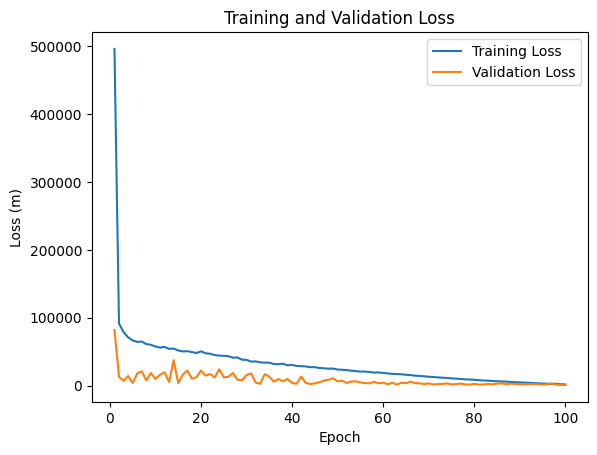

Error medio (distancia haversine): 1040.06 m
Tiempo de predicción: 0.0716 segundos


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out, _ = self.lstm2(out)
        out = self.dropout(out)
        out, _ = self.lstm3(out)
        out = self.dropout(out)
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo y medir el tiempo de predicción
with torch.no_grad():
    start_time = time.time()
    predicted_crd_tensor = model(tst_rss_tensor)
    end_time = time.time()
    prediction_time = end_time - start_time

# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
predicted_crd = predicted_crd_tensor.numpy()
true_crd = tst_crd_tensor.numpy()
distances_lstm = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio y el tiempo de predicción
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m")
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

### RNN

Epoch [1/100], Training Loss: 1828320.7775, Validation Loss: 314603.9375
Epoch [2/100], Training Loss: 438149.0695, Validation Loss: 298649.6875
Epoch [3/100], Training Loss: 292404.0187, Validation Loss: 326305.1875
Epoch [4/100], Training Loss: 189401.0292, Validation Loss: 404686.4062
Epoch [5/100], Training Loss: 123699.5145, Validation Loss: 6328872.0000
Epoch [6/100], Training Loss: 82272.4365, Validation Loss: 713071.0000
Epoch [7/100], Training Loss: 69043.5084, Validation Loss: 641618.1875
Epoch [8/100], Training Loss: 67656.3434, Validation Loss: 1597247.3750
Epoch [9/100], Training Loss: 64116.7538, Validation Loss: 5352328.5000
Epoch [10/100], Training Loss: 60858.7025, Validation Loss: 760487.9375
Epoch [11/100], Training Loss: 61757.4394, Validation Loss: 2468552.0000
Epoch [12/100], Training Loss: 59998.8591, Validation Loss: 1020767.6250
Epoch [13/100], Training Loss: 58663.3702, Validation Loss: 671596.6250
Epoch [14/100], Training Loss: 58541.6538, Validation Loss: 66

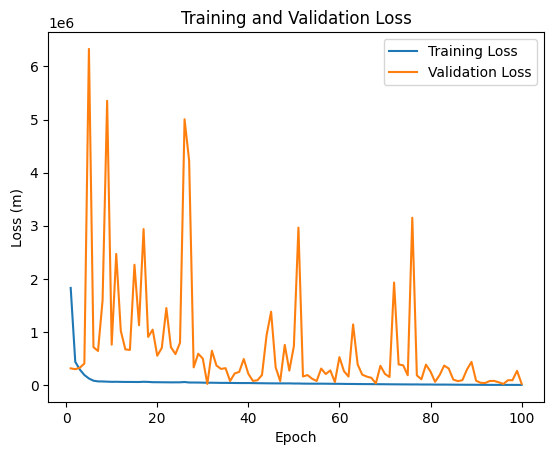

Error medio (distancia haversine): 24803.27 m
Tiempo de predicción: 0.1273 segundos


In [ ]:
# Define la arquitectura de la red LSTM
class FingerprintingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FingerprintingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn1 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.15)
        self.fc = nn.Linear(hidden_size, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(self.bn1(out))
        out, _ = self.rnn1(out)
        out = self.dropout(self.bn1(out))
        out = self.fc(out)  # Seleccionamos la última salida de la secuencia
        out = self.sigmoid(out)  # Aplicamos la función sigmoide para normalizar las salidas
        return out


class HaversineLoss(torch.nn.Module):
    def __init__(self, R=6371000):
        super(HaversineLoss, self).__init__()
        self.R = R

    def forward(self, pred_crd, true_crd):
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = torch.sin(dlat / 2) ** 2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        distance = self.R * c

        return torch.mean(distance)


# Normalizar los datos
scaler = StandardScaler()
trn_rss_normalized = scaler.fit_transform(trn_rss)
tst_rss_normalized = scaler.transform(tst_rss)

# Convertir los datos a tensores de PyTorch
trn_rss_tensor = torch.tensor(trn_rss_normalized, dtype=torch.float32)
tst_rss_tensor = torch.tensor(tst_rss_normalized, dtype=torch.float32)
trn_crd_tensor = torch.tensor(trn_crd.values, dtype=torch.float32)
tst_crd_tensor = torch.tensor(tst_crd.values, dtype=torch.float32)

# Definir el modelo LSTM
input_size = trn_rss.shape[1]  # Tamaño de entrada igual al número de características RSSI
hidden_size = 64
model = FingerprintingLSTM(input_size, hidden_size)

# Definir la función de pérdida y el optimizador
criterion = HaversineLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entrenar el modelo
num_epochs = 100
batch_size = 512
trn_dataset = torch.utils.data.TensorDataset(trn_rss_tensor, trn_crd_tensor)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)

# Definir listas para almacenar los valores de pérdida
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    trn_loss = 0.0

    # Entrenamiento del modelo
    for rss_batch, crd_batch in trn_loader:
        optimizer.zero_grad()
        output = model(rss_batch)
        loss = criterion(output, crd_batch)
        loss.backward()
        optimizer.step()
        trn_loss += loss.item() * rss_batch.size(0)

    # Evaluación en el conjunto de test
    model.eval()
    with torch.no_grad():
        tst_output = model(tst_rss_tensor)
        tst_loss = criterion(tst_output, tst_crd_tensor)

    # Calcular la pérdida media en el conjunto de entrenamiento y de test
    trn_loss /= len(trn_loader.dataset)
    tst_loss = tst_loss.item()

    # Guardar los valores de pérdida
    train_losses.append(trn_loss)
    val_losses.append(tst_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {trn_loss:.4f}, Validation Loss: {tst_loss:.4f}')

# Crear el gráfico
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (m)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluar el modelo
with torch.no_grad():
    start_time = time.time()
    predicted_crd_tensor = model(tst_rss_tensor)
    end_time = time.time()
    prediction_time = end_time - start_time


# Calcular el error medio
mean_error = criterion(predicted_crd_tensor, tst_crd_tensor).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
predicted_crd = predicted_crd_tensor.numpy()
true_crd = tst_crd_tensor.numpy()
distances_rnn = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

### XGBoost

In [ ]:
# Convertir todas las columnas a tipo numérico
trn_rss_num = trn_rss.apply(pd.to_numeric, errors='coerce')
trn_crd_num = trn_crd.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
trn_rss_num.dropna(inplace=True)
trn_crd_num.dropna(inplace=True)

# Convertir a array
tst_crd_array = tst_crd.values

# Entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(trn_rss_num, trn_crd_num)

# Función de pérdida personalizada (distancia haversine)
class HaversineLoss(nn.Module):
    def __init__(self):
        super(HaversineLoss, self).__init__()

    def forward(self, pred_crd, true_crd):
        # Radio de la Tierra en metros
        R = 6371000

        # Calcular la distancia haversine entre las coordenadas predichas y las reales
        lat1, lon1 = pred_crd[:, 1], pred_crd[:, 0]
        lat2, lon2 = true_crd[:, 1], true_crd[:, 0]

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = R * c

        return np.mean(distance)

# Realizar predicciones en el conjunto de prueba
start_time = time.time()
predicted_crd = model.predict(tst_rss)
end_time = time.time()
prediction_time = end_time - start_time

# Calcular el error medio
criterion2 = HaversineLoss()
mean_error = criterion2(predicted_crd, tst_crd_array).item()

# Calcular la distancia haversine entre las coordenadas predichas y las coordenadas reales
distances_xgboost = [haversine(pred, real) for pred, real in zip(predicted_crd, tst_crd_array)]

# Imprimir el error medio
print(f"Error medio (distancia haversine): {round(mean_error, 2)} m" )
print(f"Tiempo de predicción: {round(prediction_time, 4)} segundos")

Error medio (distancia haversine): 736.63 m
Tiempo de predicción: 0.019 segundos


### Gráfico CDF

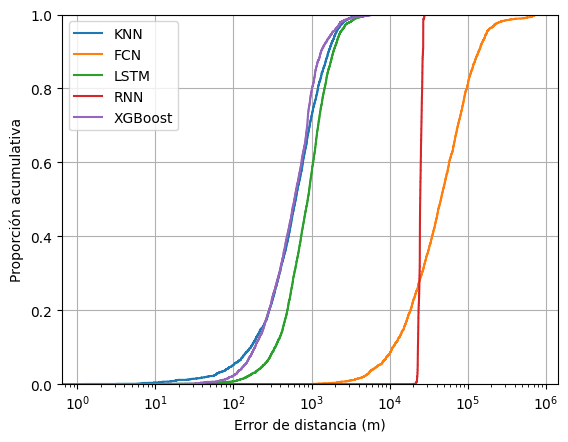

In [ ]:
# Generar el gráfico CDF
sns.ecdfplot(distances_knn, label='KNN')
sns.ecdfplot(distances_fcn, label='FCN')
sns.ecdfplot(distances_lstm, label='LSTM')
sns.ecdfplot(distances_rnn, label='RNN')
sns.ecdfplot(distances_xgboost, label='XGBoost')
plt.xscale('log')  # Cambiar la escala a logarítmica
plt.xlabel('Error de distancia (m)')
plt.ylabel('Proporción acumulativa')
plt.legend()
plt.grid(True)
plt.show()